In [1]:
import numpy as np
import csv

def read_cost_matrix_csv(filename):
    """
    Reads a cost matrix from a CSV file and returns it as a numpy array.
    
    The first row of the CSV is assumed to contain the node IDs.
    
    Parameters:
        filename (str): Name of the input CSV file.
    
    Returns:
        numpy.ndarray: The cost matrix read from the file.
    """
    with open(filename, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        # Read the first row to get the node IDs.
        node_ids = next(reader)
        # Read the remaining rows as data.
        data = list(reader)
    
    # Convert the data to a numpy array.
    cost_matrix = np.array(data, dtype=int)
    
    return cost_matrix

In [2]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt

class Optimization:
    """
    A basic TSP model for a single driver (one route) without subtour elimination.
    It uses a cost matrix to define travel costs between cities and ensures that
    each city is visited exactly once (inbound=1, outbound=1) but does NOT include
    additional constraints to prevent subtours.

    Attributes:
        cost_matrix (list of lists): 2D matrix of travel costs between cities.
        num_cities (int): Number of cities (inferred from cost_matrix).
        model (pyo.ConcreteModel): The Pyomo model built in `model()`.

    Methods:
        model(): Builds the Pyomo model with variables, objective, and constraints.
        print_model(): Prints the Pyomo model structure.
        solve_model(): Solves the model using the 'appsi_highs' solver (by default).
        print_output(): Prints/plots the resulting route(s) as a directed graph.
    """

    def __init__(self, cost_matrix):
        self.cost_matrix = cost_matrix
        self.num_cities = len(cost_matrix)  # infer number of cities from matrix size

    def model(self):
        # Create ConcreteModel
        self.model = pyo.ConcreteModel()

        # Set of cities
        self.model.N = pyo.RangeSet(1, self.num_cities)

        # Decision variables x[i, j] = 1 if we travel from city i to city j
        self.model.x = pyo.Var(self.model.N, self.model.N, within=pyo.Binary)

        # Auxiliary variable u[i] to enforce subtour elimination
        self.model.u = pyo.Var(self.model.N, within=pyo.NonNegativeIntegers, bounds=(1, self.num_cities - 1))

        # Cost parameter from cost_matrix
        def cost_init(model, i, j):
            return self.cost_matrix[i - 1][j - 1]
        self.model.c = pyo.Param(self.model.N, self.model.N, initialize=cost_init)

        # Objective function: minimize total travel cost
        def _objective_function(model):
            return sum(model.x[i, j] * model.c[i, j]
                       for i in model.N for j in model.N)
        self.model.objective = pyo.Objective(rule=_objective_function,
                                             sense=pyo.minimize)

        # Constraint: each city has exactly one outbound arc
        def _outbound_rule(model, i):
            return sum(model.x[i, j] for j in model.N if j != i) == 1
        self.model.outbound = pyo.Constraint(self.model.N, rule=_outbound_rule)

        # Constraint: each city has exactly one inbound arc
        def _inbound_rule(model, j):
            return sum(model.x[i, j] for i in model.N if i != j) == 1
        self.model.inbound = pyo.Constraint(self.model.N, rule=_inbound_rule)

        # No self-loops: x[i, i] = 0
        def _no_self_loops(model, i):
            return model.x[i, i] == 0
        self.model.no_self_loops = pyo.Constraint(self.model.N, rule=_no_self_loops)

        # Subtour elimination constraints
        def _subtour_elimination(model, i, j):
            if i != j and i != 1 and j != 1:
                return model.u[i] - model.u[j] + self.num_cities * model.x[i, j] <= self.num_cities - 1
            else:
                return pyo.Constraint.Skip

        self.model.subtour_elimination = pyo.Constraint(self.model.N, self.model.N, rule=_subtour_elimination)

    def print_model(self):
        """Prints the model structure."""
        self.model.pprint()

    def solve_model(self):
        """Solves the TSP model using the 'appsi_highs' solver."""
        solver = pyo.SolverFactory('appsi_highs')
        solver.options['parallel'] = 'on'
        solver.options['time_limit'] = 20 * 60
        solver.options['presolve'] = 'on'
        result = solver.solve(self.model, tee=True)
        print(result)

    def print_output(self):
        """
        Plots the solution as a directed graph using NetworkX and matplotlib.
        Since there's only one route (single driver), all edges are colored the same.
        """
        valid_edges = []
        for i in self.model.N:
            for j in self.model.N:
                if pyo.value(self.model.x[i, j]) > 0.5:
                    valid_edges.append((i, j))

        # Build a directed graph
        G = nx.DiGraph()
        G.add_nodes_from(self.model.N)

        # Add edges from the solution
        for (i, j) in valid_edges:
            G.add_edge(i, j)

        pos = nx.spring_layout(G)
        nx.draw_networkx(G, pos, with_labels=True,
                         node_color='lightblue',
                         edge_color='red',
                         arrows=True)
        plt.axis("off")
        plt.show()


In [ ]:
cost_matrix = read_cost_matrix_csv('cost_matrix_50_nodes_2.0_spread.csv')


opt = Optimization(cost_matrix)
opt.model()
opt.solve_model()

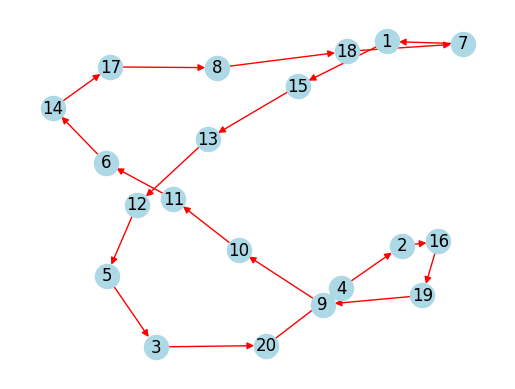

In [6]:
opt.print_output()